## 1. Preparasi

- Modelling kali ini saya menggunakan 3 model yaitu Logreg untuk baseline model dan LightGBM dan XGBoost.

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
#buat fungsi untuk reduce memory.
#intinya adalah iterasi keseluruh kolom pada dataframe dan mengubah datatype yg memorynya paling kecil.
def reduce_mem_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#fungsi untuk memanggil dataframe
def import_data(file):
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [3]:
data = import_data('G:\\Bootcamp\\Materi\\28. NoSQL\\home credit\\data\\data_final.csv')

Memory usage of dataframe is 834.43 MB
Memory usage after optimization is: 226.95 MB
Decreased by 72.8%


In [4]:
data.head()

,Unnamed: 0,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,Unnamed: 0.1,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,TARGET
0,0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,...,0,64815.0,51934,0.972168,0.972168,0.972168,0.619141,0.624512,0.634277,1.0
1,1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,...,1,9253.0,50714,0.984863,0.984863,0.984863,0.795898,0.798828,0.804199,0.0
2,2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,...,2,64815.0,50714,0.981445,0.981445,0.981445,0.755371,0.758301,0.764648,0.0
3,3,29686.5,312682.5,297000.0,135000.0,0.0,0.0,0.0,0.0,0.0,...,3,64815.0,51934,0.981445,0.981445,0.981445,0.755371,0.758301,0.764648,0.0
4,4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,...,4,64815.0,50591,0.981445,0.981445,0.981445,0.755371,0.758301,0.764648,0.0


In [5]:
data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

In [6]:
data.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,TARGET
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.014900,64815.0,51934,0.972168,0.972168,0.972168,0.619141,0.624512,0.634277,1.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.071411,9253.0,50714,0.984863,0.984863,0.984863,0.795898,0.798828,0.804199,0.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.068970,64815.0,50714,0.981445,0.981445,0.981445,0.755371,0.758301,0.764648,0.0
3,29686.5,312682.5,297000.0,135000.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.068970,64815.0,51934,0.981445,0.981445,0.981445,0.755371,0.758301,0.764648,0.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.068970,64815.0,50591,0.981445,0.981445,0.981445,0.755371,0.758301,0.764648,0.0


In [7]:
#split ke data training dan testing
data_train = data[:307511]
data_test = data[307511:]

In [8]:
data_train.shape

(307511, 305)

In [9]:
data_test.shape

(48744, 305)

## 2. Balancing Data
- Menggunakan Undersampling random under sampling.

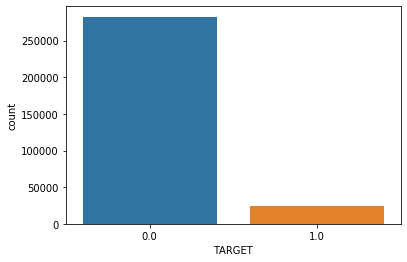

In [10]:
#Data belum balance
sns.countplot(data['TARGET'])

In [11]:
x = data_train.drop(columns=['TARGET', 'SK_ID_CURR'])
y = data_train['TARGET']

In [12]:
x.shape

(307511, 303)

In [13]:
y.shape

(307511,)

In [14]:
rus = RandomUnderSampler()
x_resample, y_resample = rus.fit_sample(x,y)

In [15]:
print(x_resample.shape)
print(y_resample.shape)

(49650, 303)
(49650,)


## 3. Rescaling Data

- agar data memiliki satuan yang sama

In [16]:
scaler = MinMaxScaler()

In [17]:
x_resample = scaler.fit_transform(x_resample)

## 4. Baseline Model Logistic Regression

In [18]:
#data testing
data_test_2 = data_test.copy()

#drop unused columns
data_test_2.drop(columns=['SK_ID_CURR', 'TARGET'], inplace=True)

#rescale
x_test = scaler.fit_transform(data_test_2)

In [19]:
log_reg = LogisticRegression(C=0.0001)

In [20]:
log_reg.fit(x_resample, y_resample)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
y_pred = log_reg.predict_proba(x_test)[:,1]

In [22]:
submission = data_test[['SK_ID_CURR']]

In [23]:
submission['TARGET'] = y_pred

In [24]:
submission.head()

,SK_ID_CURR,TARGET
307511,100001,0.483858
307512,100005,0.531533
307513,100013,0.467194
307514,100028,0.474267
307515,100038,0.553224


In [25]:
submission.to_csv('log_reg_submission.csv', index=False)

- AUC Score 0.68 from kaggle.

## 5. Advanced Model LightGBM

In [26]:
lgbm = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.03,
        num_leaves=34,
        colsample_bytree=0.9,
        subsample=0.8,
        max_depth=8,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=300,
        silent=-1,
        verbose=-1,
        )

In [27]:
lgbm.fit(x_resample, y_resample)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
               importance_type='split', learning_rate=0.03, max_depth=8,
               min_child_samples=20, min_child_weight=300, min_split_gain=0.01,
               n_estimators=10000, n_jobs=-1, num_leaves=34, objective=None,
               random_state=None, reg_alpha=0.1, reg_lambda=0.1, silent=-1,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0,
               verbose=-1)

In [28]:
y_pred_2 = lgbm.predict_proba(x_test)[:,1]

In [29]:
submission_2 = data_test[['SK_ID_CURR']]
submission_2['TARGET'] = y_pred_2
submission_2.head()

,SK_ID_CURR,TARGET
307511,100001,0.446417
307512,100005,0.695179
307513,100013,0.052643
307514,100028,0.124402
307515,100038,0.593963


In [30]:
submission_2.to_csv('lightGBM_submission.csv', index=False)

- Score AUC 0.70516 dari Kaggle 

## 6. Advanced Model XGBoost

In [31]:
xgb = XGBClassifier(
        objective="binary:logistic",
        booster="gbtree",
        eval_metric = "auc",
        nthread = 4,
        eta = 0.05,
        gamma = 0,
        max_depth = 6,
        subsample=0.7,
        colsample_bytree = 0.7,
        colsample_bylevel = 0.675,
        min_child_weight = 22,
        alpha = 0,
        random_state = 42,
        nrounds = 2000
    )

In [32]:
xgb.fit(x_resample, y_resample)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
              colsample_bylevel=0.675, colsample_bynode=1, colsample_bytree=0.7,
              eta=0.05, eval_metric='auc', gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=6, min_child_weight=22, missing=None,
              n_estimators=100, n_jobs=1, nrounds=2000, nthread=4,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.7, verbosity=1)

In [33]:
y_pred_3 = xgb.predict_proba(x_test)[:,1]

In [34]:
submission_3 = data_test[['SK_ID_CURR']]
submission_3['TARGET'] = y_pred_3
submission_3.head()

,SK_ID_CURR,TARGET
307511,100001,0.290917
307512,100005,0.534497
307513,100013,0.137958
307514,100028,0.363733
307515,100038,0.533783


In [35]:
submission_3.to_csv('XGB_submission.csv', index=False)

- Dengan XGBoost model didapatkan score AUC 0.72373 dari kaggle.